In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

In [31]:
#interest_rate = pd.read_csv("./대출금리.csv" )
#buy_index = pd.read_csv("./아파트매매가격지수.csv")
#year_index = pd.read_csv("./아파트전세가격지수.csv")
#seoul_gu = pd.read_csv("./서울시 구.csv")
#buy_year_rate = pd.read_csv("./아파트 매매가격대비 전세가격비율.csv")

interest_rate = pd.read_csv("./대출금리200212.csv" )
seoul_gu = pd.read_csv("./서울시 구.csv")
buy_index = pd.read_csv("./월간 아파트 매매가격지수_20240129.csv")
year_index = pd.read_csv("./월간 아파트 전세가격지수_20240129.csv")
buy_year_rate = pd.read_csv("./아파트 매매가격대비 전세가격비율_20240129.csv")
seoul_buy_year_rate = pd.read_csv("./아파트 서울 매매가격대비 전세가격비율_20240129.csv")
seoul_buy_index = pd.read_csv("./월간 서울 아파트 매매가격지수_20240129.csv")
seoul_year_index = pd.read_csv("./월간 서울 아파트 전세가격지수_20240129.csv")

# 1. 전처리

### 1. 주택금리 전처리

##### 1.1) 주택담보대출 (연리%)만 가져오기

In [32]:
interest_rate2 = interest_rate[interest_rate['계정항목별'] == interest_rate['계정항목별'][10]].transpose().reset_index(drop=False).iloc[1:]
interest_rate2.columns = ['날짜', '주택담보대출 (연리%)']

1.2) 날짜 형식 통일

In [33]:
interest_rate2['날짜'] = pd.to_datetime(interest_rate2['날짜'])

In [34]:
interest_rate3 = interest_rate2.set_index('날짜')
interest_rate3 = interest_rate3.applymap(lambda x: pd.to_numeric(x, errors='coerce')) #수치형 변환 추가

In [35]:
interest_rate3 = interest_rate3.iloc[1:] #2003-01-01	~ 2023-11-01

## 전처리 함수

In [36]:
def region(df) :
  #전국, 광역시 단위 가져오기
  temp = df[df['지역명'].str.contains('전국|서울|강북14개구|강남11개구|6개광역시|부산|대전|대구|인천|광주|울산')].transpose().reset_index(drop=False).iloc[1:]
  temp.columns = ['날짜','전국','서울', '강북14개구', '강남11개구', '6개광역시', '부산', '대전', '대구', '인천', '광주', '울산']

  #날짜 형식 통일
  temp['날짜'] = [datetime.strptime(date, "%b-%y") for date in temp['날짜']]
  temp2 = temp.set_index('날짜')
  temp3 = temp2.applymap(lambda x: pd.to_numeric(x, errors='coerce')) #수치형 변환 추가

  ##2003-01-01	~ 2023-11-01까지만 가져오기
  temp4 = temp3.loc['2003-01-01':'2023-11-01']

  return(temp4)

In [37]:
bin = ['날짜']
gu_list = seoul_buy_index.transpose().iloc[0].to_list()

def seoul(df) :
  #서울시만 가져오기
  temp = df.transpose().reset_index().iloc[1:]
  temp.columns = bin + gu_list

  #날짜 형식 통일
  try:
    temp2 = temp.set_index('날짜')['03-Jan':'23-Nov']
  except KeyError:
    temp2 = temp.set_index('날짜')['Jan-03':'Nov-23']
  temp2.index = region_buy.index
  temp3 = temp2.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

  return(temp3)

### 2. 아파트 매매가격지수 전처리

In [38]:
#아파트 매매가격지수
region_buy = region(buy_index) # 전국
seoul_buy = seoul(seoul_buy_index) # 서울

### 3. 아파트 전세가격지수 전처리

In [39]:
#아파트 전세가격지수
region_year_index = region(year_index) # 전국
seoul_year_index = seoul(seoul_year_index) # 서울

### 4. 전세/매매가격 지수 비율 전처리

In [40]:
#아파트 전세가격지수
region_buy_year_rate = region(buy_year_rate) # 전국
seoul_buy_year_rate = seoul(seoul_buy_year_rate) # 서울

### 5. 결측치 처리 (선형보간법)

In [41]:
Gangbook = ['종로구','중구','용산구', '성동구', '광진구', '동대문구', '중랑구',	'성북구',	'강북구'	,'도봉구',	'노원구',	'은평구',	'서대문구',	'마포구']
Gangnam = ['양천구'	,'강서구',	'구로구',	'금천구',	'영등포구',	'동작구',	'관악구',	'서초구'	,'강남구',	'송파구',	'강동구']

# 보간 수행
seoul_buy_year_rate_in = seoul_buy_year_rate.interpolate(method='linear', limit_direction='both')

# 강남, 강북, 서울 전체의 평균 계산
seoul_buy_year_rate_in['강남평균'] = seoul_buy_year_rate_in[Gangnam].mean(axis=1)
seoul_buy_year_rate_in['강북평균'] = seoul_buy_year_rate_in[Gangbook].mean(axis=1)
seoul_buy_year_rate_in['서울평균'] = seoul_buy_year_rate_in.mean(axis=1)

# 실제 평균과의 차이 계산
diff_gangnam = region_buy_year_rate['강남11개구'] - seoul_buy_year_rate_in['강남평균']
diff_gangbuk = region_buy_year_rate['강북14개구'] - seoul_buy_year_rate_in['강북평균']
diff_seoul = region_buy_year_rate['서울'] - seoul_buy_year_rate_in['서울평균']

# 각 구별 차이를 반영하여 실제 평균과 일치하도록 조정
for 구 in Gangnam:
    seoul_buy_year_rate_in[구] += diff_gangnam

for 구 in Gangbook:
    seoul_buy_year_rate_in[구] += diff_gangbuk

# 서울 전체 평균에 맞추어 조정
seoul_buy_year_rate_in.update(region_buy_year_rate['서울'], overwrite=False)
seoul_buy_year_rate_in = seoul_buy_year_rate_in.drop(columns =['강남평균', '강북평균', '서울평균'], axis = 1)
seoul_buy_year_rate = seoul_buy_year_rate_in

### 6. 임대료 데이터 만들기
(전세 지수 : year_index)* (전세/매매가격 지수 : year_buy_rate ) * (주택담보대출금리(%) : interest_rate / 1200 + 1)

In [42]:
def rent(df, year_index) :
  #1) (전세/매매가격 지수)/100 * (주택담보대출금리(%) / 1200 + 1)
  columns = df.columns
  df2 = df.reset_index()
  for i in columns  :
    df2[i] = df2[i]/100 * (interest_rate3.reset_index()['주택담보대출 (연리%)'] /100+ 1)

  #2) (전세 지수) * 위 블록 결과(year_buy_rate4)
  df2 = df2.set_index('날짜') # (전세/매매가격 지수) * (주택담보대출금리(%) / 12 /100+1)

  rent = year_index * df2/12
  return(rent)

In [43]:
seoul_rent = rent(seoul_buy_year_rate, seoul_year_index)
region_rent = rent(region_buy_year_rate, region_year_index)

In [44]:
# Initialize dictionaries to store the data frames
buy_data_frames = {}
rent_data_frames = {}

# Iterate over columns (districts) in the data frames
for district in seoul_buy.columns:
    # Create a copy of the column data for each district
    buy_data_frames[district] = seoul_buy[district].copy()
    rent_data_frames[district] = seoul_rent[district].copy()

# Kalman Filter and Optimization

In [45]:
# Define the Kalman filter function

def kalman_filter(y, x, theta):
    # Unpack the parameters from theta
    beta, phi, sigma_b, sigma_s, sigma_zeta = theta
    rho = 1 / beta
    psi = 1 / (1 - phi * rho)
    
    # Define state-space matrices
    F = np.array([[beta, 0], [0, 1]])
    H = np.array([[1, 0]])
    A = np.array([[0, 0], [0, 0]])
    B = np.array([[psi, 1 - psi], [0, phi]])
    V = np.diag([sigma_b**2, sigma_s**2])
    R = np.array([[sigma_zeta**2]])
    
    # Initialize state and covariance estimates
    z_t_t = np.zeros((2, 1))
    P_t_t = np.eye(2)
    
    log_likelihood = 0
    for t in range(1, len(y)):
        # Prepare the input vector with lagged values
        x_t = np.array([[x.iloc[t]], [x.iloc[t-1] if t-1 >= 0 else 0]])
        
        # Prediction step
        z_t_t_1 = F @ z_t_t + A @ x_t
        P_t_t_1 = F @ P_t_t @ F.T + V
        
        # Measurement update
        y_t = np.array([[y.iloc[t]]])  # Shape (1, 1)
        predicted_observation = H @ z_t_t_1 + B @ x_t  # Shape should be (1, 1)
        epsilon_t_t_1 = y_t - predicted_observation[0, 0]  # Result is scalar, shape (1, 1)
        D_t_t_1 = H @ P_t_t_1 @ H.T + R  # Shape (1, 1)
        K = P_t_t_1 @ H.T @ np.linalg.inv(D_t_t_1)  # Shape (2, 1)
        
        z_t_t = z_t_t_1 + K * epsilon_t_t_1  # Scalar multiplication, shape (2, 1)
        P_t_t = P_t_t_1 - K @ H @ P_t_t_1  # Shape (2, 2)


        
        # Update log-likelihood
        log_likelihood -= 0.5 * (np.log(2 * np.pi) + np.log(np.linalg.det(D_t_t_1)) +
                                  epsilon_t_t_1.T @ np.linalg.inv(D_t_t_1) @ epsilon_t_t_1)

    return -log_likelihood.item()  # Negative because we will minimize

def estimate_parameters(y, x):
    # Define bounds for each parameter
    bounds = [(0.01, 1),  # beta
              (-1, 1),    # phi
              (1e-5, 2),  # sigma_b
              (1e-5, 2),  # sigma_s
              (1e-5, 2)]  # sigma_zeta

    # Optimization routine with additional settings
    result = differential_evolution(lambda theta: kalman_filter(y, x, theta), 
                                    bounds, 
                                    maxiter=1000,  # Increase maximum number of iterations
                                    tol=1e-6,      # Set a lower tolerance
                                    popsize=15,    # Adjust population size if needed
                                    mutation=(0.5, 1),  # Mutation range
                                    recombination=0.7,  # Recombination rate
                                    disp=True)     # Display progress

    # Check if the optimization was successful
    if not result.success:
        raise Exception('Optimization did not converge: ', result.message)

    # Estimated parameters
    estimated_theta = result.x
    return estimated_theta

## Bayesian Optimization

In [46]:
# from functools import partial
# from bayes_opt import BayesianOptimization

# def kalman_filter_objective(beta, phi, sigma_b, sigma_s, sigma_zeta, y, x):
#     theta = [beta, phi, sigma_b, sigma_s, sigma_zeta]
#     return -kalman_filter(y, x, theta)

# def estimate_parameters(y, x):
#     # Define the parameter bounds
#     pbounds = {
#         'beta': (0.01, 1),
#         'phi': (-1, 1),
#         'sigma_b': (1e-5, 2),
#         'sigma_s': (1e-5, 2),
#         'sigma_zeta': (1e-5, 2)
#     }
#     objective_with_data = partial(kalman_filter_objective, y=y, x=x)

#     optimizer = BayesianOptimization(
#         f=objective_with_data,
#         pbounds=pbounds,
#         random_state=1
#     )

#     optimizer.maximize(
#         init_points=2,  # Number of random initial points
#         n_iter=100,      # Number of iterations
#     )

#      # Extract the best parameters
#     best_params = optimizer.max['params']
#     estimated_theta = [best_params['beta'], best_params['phi'], best_params['sigma_b'], 
#                        best_params['sigma_s'], best_params['sigma_zeta']]
#     return estimated_theta

# # Run the estimation routine
# estimated_theta = estimate_parameters(y, x)
# print('Estimated parameters:', estimated_theta)

## Run Kalman filter with estimated parameters

In [47]:
def run_kalman_filter(y, x, theta):
    # Unpack the estimated parameters
    beta, phi, sigma_b, sigma_s, sigma_zeta = theta
    rho = 1 / beta
    psi = 1 / (1 - phi * rho)

    # Define state-space matrices
    F = np.array([[beta, 0], [0, 1]])
    H = np.array([[1, 0]])
    A = np.array([[0, 0], [0, 0]])
    B = np.array([[psi, 1 - psi], [0, phi]])
    V = np.diag([sigma_b**2, sigma_s**2])
    R = np.array([[sigma_zeta**2]])
    
    # Initialize state and covariance estimates
    z_t_t = np.zeros((2, 1))
    P_t_t = np.eye(2)

    # Store the state estimates for each period
    z_estimates = []

    for t in range(1, len(y)):
        # Prepare the input vector with lagged values
        x_t = np.array([[x.iloc[t]], [x.iloc[t-1] if t-1 >= 0 else 0]])

        # Prediction step
        z_t_t_1 = F @ z_t_t + A @ x_t
        P_t_t_1 = F @ P_t_t @ F.T + V

        # Measurement update
        y_t = np.array([[y.iloc[t]]])
        epsilon_t_t_1 = y_t - (H @ z_t_t_1 + B @ x_t)[0, 0]
        D_t_t_1 = H @ P_t_t_1 @ H.T + R
        K = P_t_t_1 @ H.T @ np.linalg.inv(D_t_t_1)
        
        z_t_t = z_t_t_1 + K * epsilon_t_t_1
        P_t_t = P_t_t_1 - K @ H @ P_t_t_1

        # Store the state estimate
        z_estimates.append(z_t_t.copy())

    return np.array(z_estimates).squeeze()

differential_evolution step 1: f(x)= 78.296
differential_evolution step 2: f(x)= 78.296
differential_evolution step 3: f(x)= 73.5985
differential_evolution step 4: f(x)= 73.5985
differential_evolution step 5: f(x)= 73.5985
differential_evolution step 6: f(x)= 73.5985
differential_evolution step 7: f(x)= 73.5985
differential_evolution step 8: f(x)= 73.4714
differential_evolution step 9: f(x)= 73.4714
differential_evolution step 10: f(x)= 73.4542
differential_evolution step 11: f(x)= 73.4542
differential_evolution step 12: f(x)= 73.4542
differential_evolution step 13: f(x)= 73.4412
differential_evolution step 14: f(x)= 73.4412
differential_evolution step 15: f(x)= 73.4209
differential_evolution step 16: f(x)= 73.4167
differential_evolution step 17: f(x)= 73.4167
differential_evolution step 18: f(x)= 73.4167
differential_evolution step 19: f(x)= 73.4128
differential_evolution step 20: f(x)= 73.4128
differential_evolution step 21: f(x)= 73.4128
differential_evolution step 22: f(x)= 73.4128

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


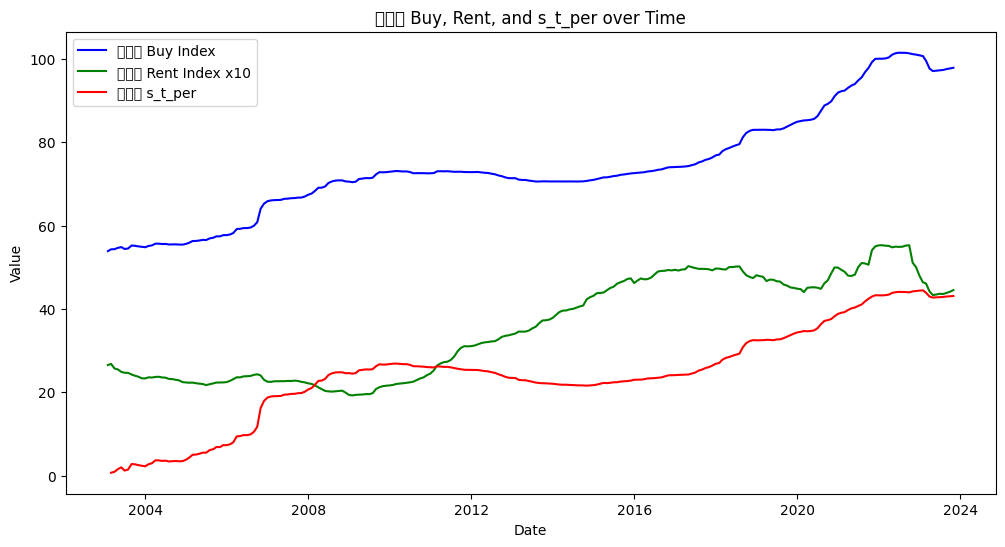

differential_evolution step 1: f(x)= 99.2076
differential_evolution step 2: f(x)= 99.2076
differential_evolution step 3: f(x)= 86.192
differential_evolution step 4: f(x)= 72.0244
differential_evolution step 5: f(x)= 71.024
differential_evolution step 6: f(x)= 71.024
differential_evolution step 7: f(x)= 70.2988
differential_evolution step 8: f(x)= 70.2988
differential_evolution step 9: f(x)= 69.584
differential_evolution step 10: f(x)= 69.584
differential_evolution step 11: f(x)= 69.584
differential_evolution step 12: f(x)= 69.2094
differential_evolution step 13: f(x)= 69.1817
differential_evolution step 14: f(x)= 68.7448
differential_evolution step 15: f(x)= 68.6639
differential_evolution step 16: f(x)= 68.6537
differential_evolution step 17: f(x)= 68.5709
differential_evolution step 18: f(x)= 68.4289
differential_evolution step 19: f(x)= 68.4289
differential_evolution step 20: f(x)= 68.3991
differential_evolution step 21: f(x)= 68.3991
differential_evolution step 22: f(x)= 68.3991
dif

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


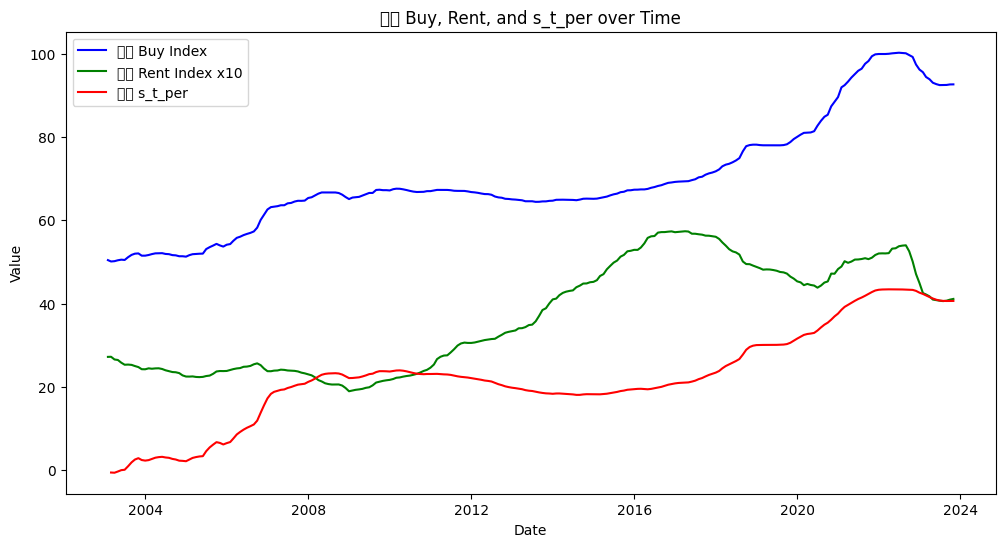

differential_evolution step 1: f(x)= 104.666
differential_evolution step 2: f(x)= 104.666
differential_evolution step 3: f(x)= 103.767
differential_evolution step 4: f(x)= 103.767
differential_evolution step 5: f(x)= 103.288
differential_evolution step 6: f(x)= 102.488
differential_evolution step 7: f(x)= 102.466
differential_evolution step 8: f(x)= 102.036
differential_evolution step 9: f(x)= 102.036
differential_evolution step 10: f(x)= 102.036
differential_evolution step 11: f(x)= 102.036
differential_evolution step 12: f(x)= 102.036
differential_evolution step 13: f(x)= 102.036
differential_evolution step 14: f(x)= 102.008
differential_evolution step 15: f(x)= 102.008
differential_evolution step 16: f(x)= 102.008
differential_evolution step 17: f(x)= 102.008
differential_evolution step 18: f(x)= 102
differential_evolution step 19: f(x)= 102
differential_evolution step 20: f(x)= 102
differential_evolution step 21: f(x)= 102
differential_evolution step 22: f(x)= 101.987
differential_

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


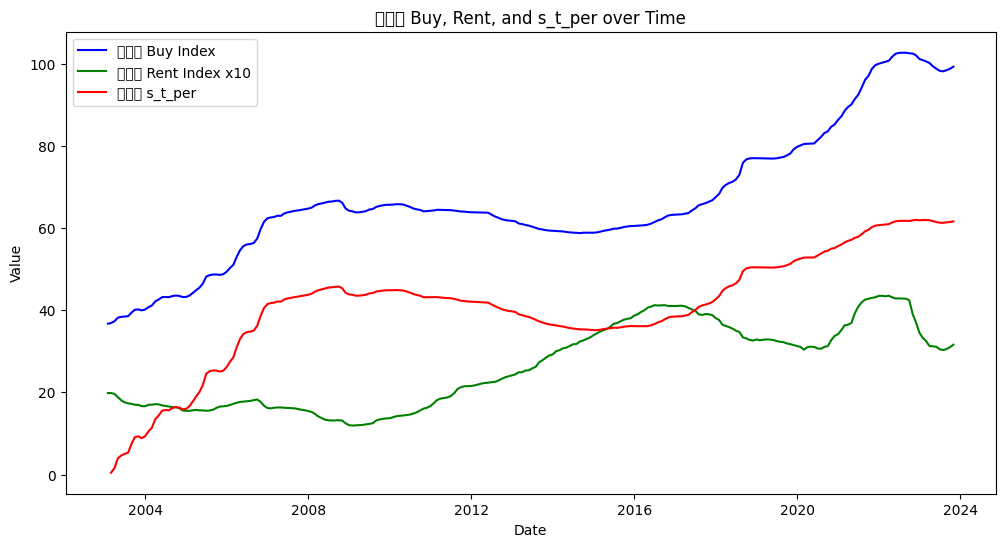

differential_evolution step 1: f(x)= 146.503
differential_evolution step 2: f(x)= 141.518
differential_evolution step 3: f(x)= 128.497
differential_evolution step 4: f(x)= 123.532
differential_evolution step 5: f(x)= 122.435
differential_evolution step 6: f(x)= 122.016
differential_evolution step 7: f(x)= 122.016
differential_evolution step 8: f(x)= 121.448
differential_evolution step 9: f(x)= 121.323
differential_evolution step 10: f(x)= 121.132
differential_evolution step 11: f(x)= 121.132
differential_evolution step 12: f(x)= 121.132
differential_evolution step 13: f(x)= 121.046
differential_evolution step 14: f(x)= 121.046
differential_evolution step 15: f(x)= 120.923
differential_evolution step 16: f(x)= 120.923
differential_evolution step 17: f(x)= 120.923
differential_evolution step 18: f(x)= 120.923
differential_evolution step 19: f(x)= 120.896
differential_evolution step 20: f(x)= 120.896
differential_evolution step 21: f(x)= 120.896
differential_evolution step 22: f(x)= 120.8

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


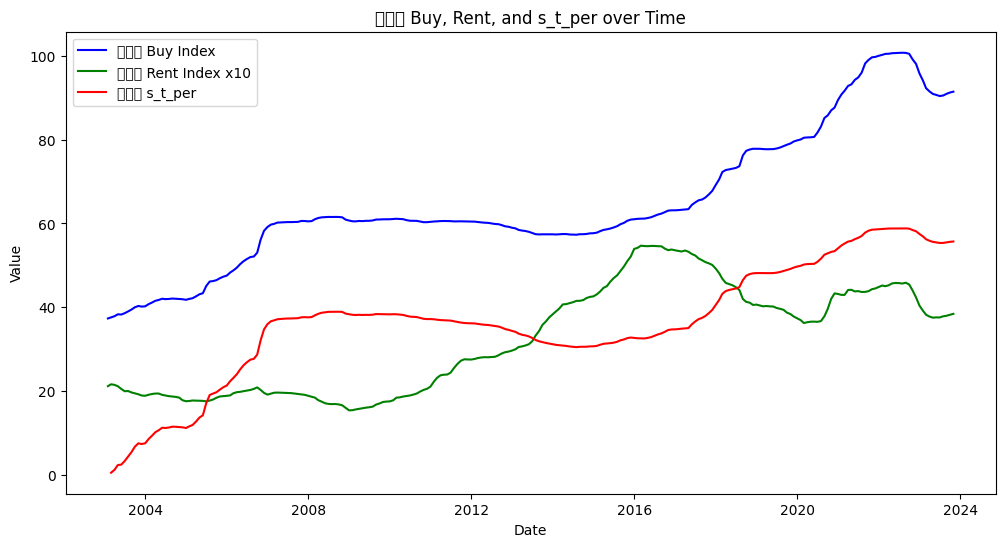

differential_evolution step 1: f(x)= 114.801
differential_evolution step 2: f(x)= 114.801
differential_evolution step 3: f(x)= 114.801
differential_evolution step 4: f(x)= 114.801
differential_evolution step 5: f(x)= 112.961
differential_evolution step 6: f(x)= 112.961
differential_evolution step 7: f(x)= 112.961
differential_evolution step 8: f(x)= 112.795
differential_evolution step 9: f(x)= 112.486
differential_evolution step 10: f(x)= 112.486
differential_evolution step 11: f(x)= 112.486
differential_evolution step 12: f(x)= 112.474
differential_evolution step 13: f(x)= 112.299
differential_evolution step 14: f(x)= 112.299
differential_evolution step 15: f(x)= 112.299
differential_evolution step 16: f(x)= 112.276
differential_evolution step 17: f(x)= 112.276
differential_evolution step 18: f(x)= 112.276
differential_evolution step 19: f(x)= 112.276
differential_evolution step 20: f(x)= 112.276
differential_evolution step 21: f(x)= 112.276
differential_evolution step 22: f(x)= 112.2

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


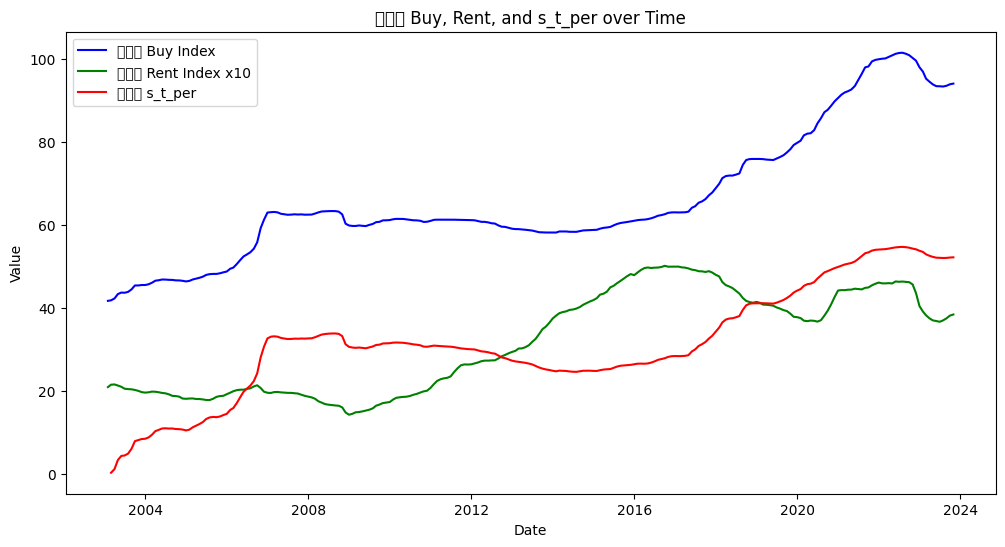

differential_evolution step 1: f(x)= 121.435
differential_evolution step 2: f(x)= 121.435
differential_evolution step 3: f(x)= 108.661
differential_evolution step 4: f(x)= 107.389
differential_evolution step 5: f(x)= 107.35
differential_evolution step 6: f(x)= 107.35
differential_evolution step 7: f(x)= 106.655
differential_evolution step 8: f(x)= 106.655
differential_evolution step 9: f(x)= 106.255
differential_evolution step 10: f(x)= 106.255
differential_evolution step 11: f(x)= 105.811
differential_evolution step 12: f(x)= 105.68
differential_evolution step 13: f(x)= 105.68
differential_evolution step 14: f(x)= 105.68
differential_evolution step 15: f(x)= 105.68
differential_evolution step 16: f(x)= 105.68
differential_evolution step 17: f(x)= 105.68
differential_evolution step 18: f(x)= 105.68
differential_evolution step 19: f(x)= 105.57
differential_evolution step 20: f(x)= 105.568
differential_evolution step 21: f(x)= 105.523
differential_evolution step 22: f(x)= 105.523
differe

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


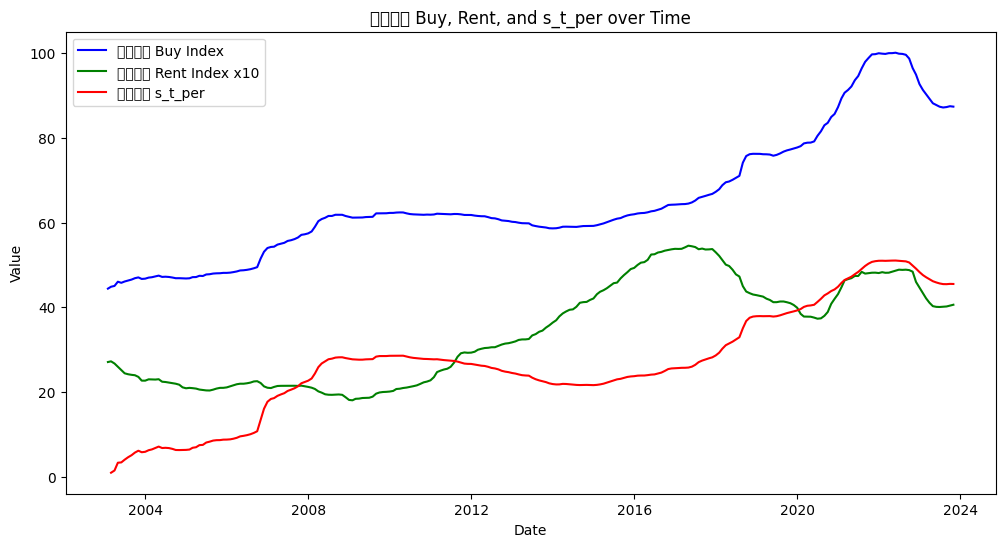

differential_evolution step 1: f(x)= 92.3868
differential_evolution step 2: f(x)= 80.5104
differential_evolution step 3: f(x)= 80.5104
differential_evolution step 4: f(x)= 80.4738
differential_evolution step 5: f(x)= 80.1918
differential_evolution step 6: f(x)= 78.9024
differential_evolution step 7: f(x)= 77.6002
differential_evolution step 8: f(x)= 77.6002
differential_evolution step 9: f(x)= 77.1936
differential_evolution step 10: f(x)= 77.153
differential_evolution step 11: f(x)= 76.8752
differential_evolution step 12: f(x)= 76.8752
differential_evolution step 13: f(x)= 76.8703
differential_evolution step 14: f(x)= 76.8165
differential_evolution step 15: f(x)= 76.7946
differential_evolution step 16: f(x)= 76.7946
differential_evolution step 17: f(x)= 76.7946
differential_evolution step 18: f(x)= 76.792
differential_evolution step 19: f(x)= 76.792
differential_evolution step 20: f(x)= 76.7856
differential_evolution step 21: f(x)= 76.7856
differential_evolution step 22: f(x)= 76.7851


c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46993 (\N{HANGUL SYLLABLE RANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


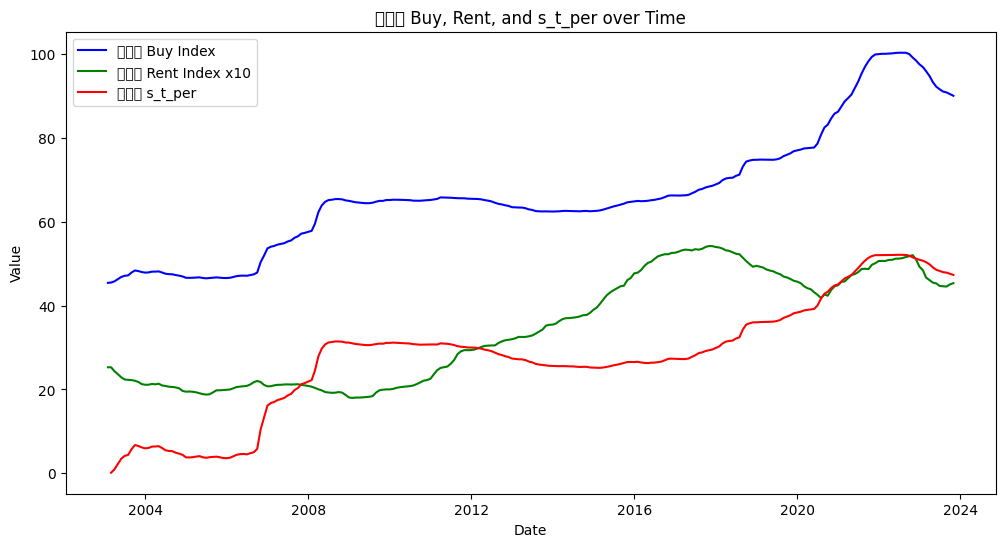

differential_evolution step 1: f(x)= 124.54
differential_evolution step 2: f(x)= 102.16
differential_evolution step 3: f(x)= 92.2505
differential_evolution step 4: f(x)= 92.2505
differential_evolution step 5: f(x)= 92.2505
differential_evolution step 6: f(x)= 92.2505
differential_evolution step 7: f(x)= 91.4991
differential_evolution step 8: f(x)= 91.4991
differential_evolution step 9: f(x)= 91.4991
differential_evolution step 10: f(x)= 91.4991
differential_evolution step 11: f(x)= 91.4991
differential_evolution step 12: f(x)= 91.4991
differential_evolution step 13: f(x)= 91.4991
differential_evolution step 14: f(x)= 91.2898
differential_evolution step 15: f(x)= 91.2898
differential_evolution step 16: f(x)= 91.1079
differential_evolution step 17: f(x)= 91.1079
differential_evolution step 18: f(x)= 91.1079
differential_evolution step 19: f(x)= 91.0854
differential_evolution step 20: f(x)= 91.0854
differential_evolution step 21: f(x)= 91.0854
differential_evolution step 22: f(x)= 91.085


c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


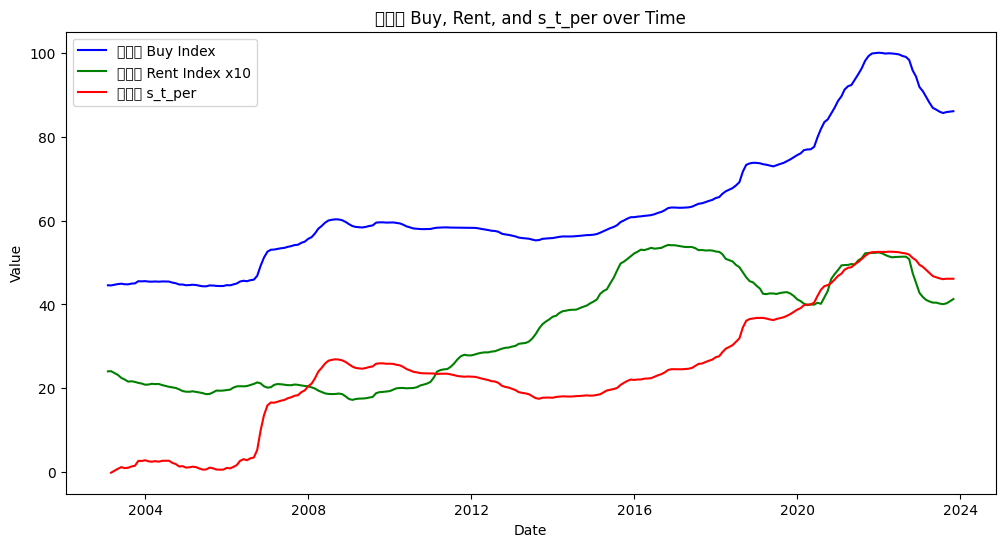

differential_evolution step 1: f(x)= 177.212
differential_evolution step 2: f(x)= 152.847
differential_evolution step 3: f(x)= 141.232
differential_evolution step 4: f(x)= 141.232
differential_evolution step 5: f(x)= 141.232
differential_evolution step 6: f(x)= 140.49
differential_evolution step 7: f(x)= 140.49
differential_evolution step 8: f(x)= 140.49
differential_evolution step 9: f(x)= 139.581
differential_evolution step 10: f(x)= 138.51
differential_evolution step 11: f(x)= 138.51
differential_evolution step 12: f(x)= 137.846
differential_evolution step 13: f(x)= 137.846
differential_evolution step 14: f(x)= 137.846
differential_evolution step 15: f(x)= 137.811
differential_evolution step 16: f(x)= 137.811
differential_evolution step 17: f(x)= 137.757
differential_evolution step 18: f(x)= 137.757
differential_evolution step 19: f(x)= 137.757
differential_evolution step 20: f(x)= 137.71
differential_evolution step 21: f(x)= 137.695
differential_evolution step 22: f(x)= 137.693
dif

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


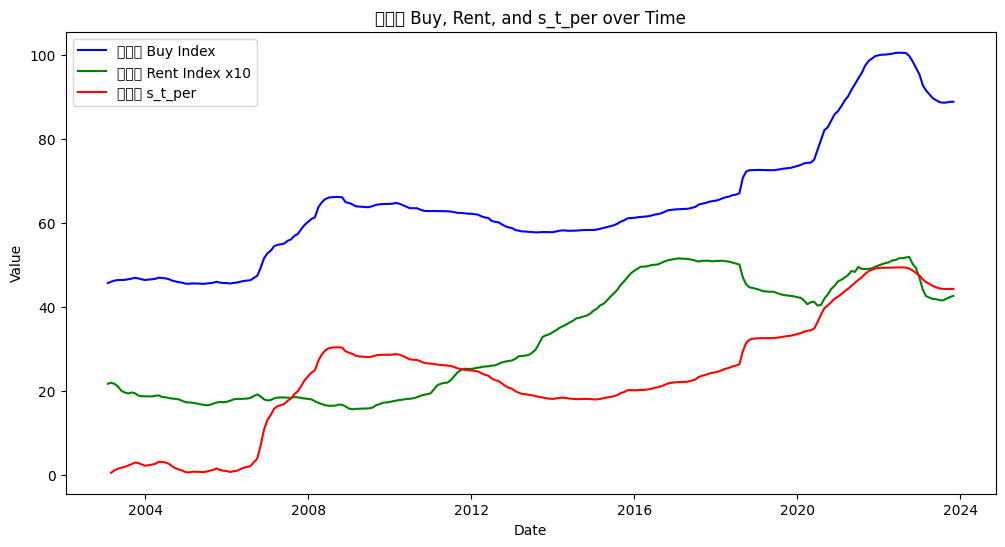

differential_evolution step 1: f(x)= 147.151
differential_evolution step 2: f(x)= 147.151
differential_evolution step 3: f(x)= 147.151
differential_evolution step 4: f(x)= 143.217
differential_evolution step 5: f(x)= 143.217
differential_evolution step 6: f(x)= 141.96
differential_evolution step 7: f(x)= 141.96
differential_evolution step 8: f(x)= 141.96
differential_evolution step 9: f(x)= 141.96
differential_evolution step 10: f(x)= 141.96
differential_evolution step 11: f(x)= 141.94
differential_evolution step 12: f(x)= 141.827
differential_evolution step 13: f(x)= 141.827
differential_evolution step 14: f(x)= 141.619
differential_evolution step 15: f(x)= 141.619
differential_evolution step 16: f(x)= 141.607
differential_evolution step 17: f(x)= 141.607
differential_evolution step 18: f(x)= 141.607
differential_evolution step 19: f(x)= 141.605
differential_evolution step 20: f(x)= 141.601
differential_evolution step 21: f(x)= 141.585
differential_evolution step 22: f(x)= 141.585
dif

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48393 (\N{HANGUL SYLLABLE BONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


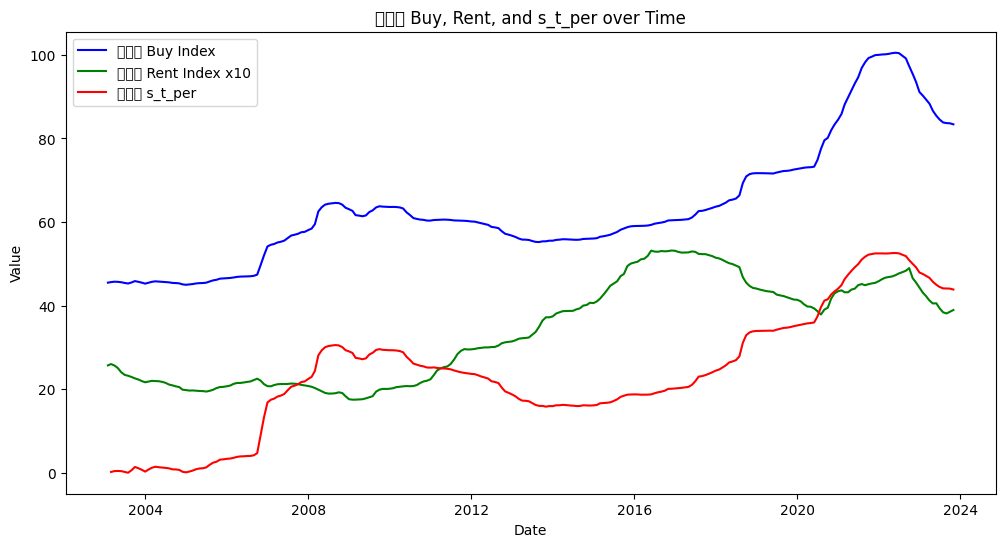

differential_evolution step 1: f(x)= 171.868
differential_evolution step 2: f(x)= 171.868
differential_evolution step 3: f(x)= 166.262
differential_evolution step 4: f(x)= 161.413
differential_evolution step 5: f(x)= 161.413
differential_evolution step 6: f(x)= 160.803
differential_evolution step 7: f(x)= 160.803
differential_evolution step 8: f(x)= 158.879
differential_evolution step 9: f(x)= 158.879
differential_evolution step 10: f(x)= 158.879
differential_evolution step 11: f(x)= 158.879
differential_evolution step 12: f(x)= 158.879
differential_evolution step 13: f(x)= 158.832
differential_evolution step 14: f(x)= 158.619
differential_evolution step 15: f(x)= 158.468
differential_evolution step 16: f(x)= 158.362
differential_evolution step 17: f(x)= 158.318
differential_evolution step 18: f(x)= 158.318
differential_evolution step 19: f(x)= 158.318
differential_evolution step 20: f(x)= 158.318
differential_evolution step 21: f(x)= 158.318
differential_evolution step 22: f(x)= 158.3

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


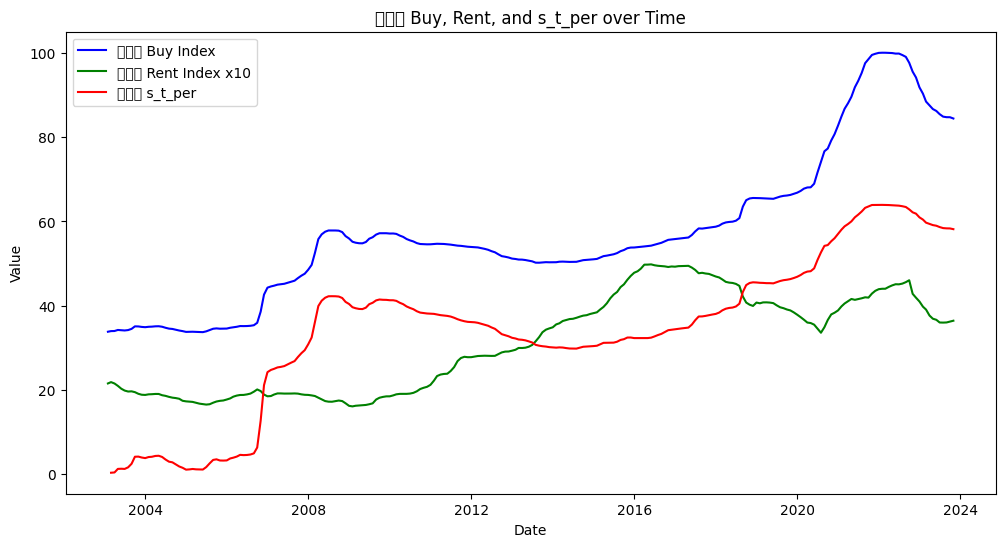

differential_evolution step 1: f(x)= 81.2631
differential_evolution step 2: f(x)= 81.2631
differential_evolution step 3: f(x)= 81.2631
differential_evolution step 4: f(x)= 80.8739
differential_evolution step 5: f(x)= 80.5323
differential_evolution step 6: f(x)= 78.4057
differential_evolution step 7: f(x)= 78.4057
differential_evolution step 8: f(x)= 78.4057
differential_evolution step 9: f(x)= 78.4057
differential_evolution step 10: f(x)= 77.7845
differential_evolution step 11: f(x)= 77.6257
differential_evolution step 12: f(x)= 77.6171
differential_evolution step 13: f(x)= 77.5333
differential_evolution step 14: f(x)= 77.5333
differential_evolution step 15: f(x)= 77.5333
differential_evolution step 16: f(x)= 77.5333
differential_evolution step 17: f(x)= 77.5333
differential_evolution step 18: f(x)= 77.5323
differential_evolution step 19: f(x)= 77.53
differential_evolution step 20: f(x)= 77.5219
differential_evolution step 21: f(x)= 77.5168
differential_evolution step 22: f(x)= 77.5168

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


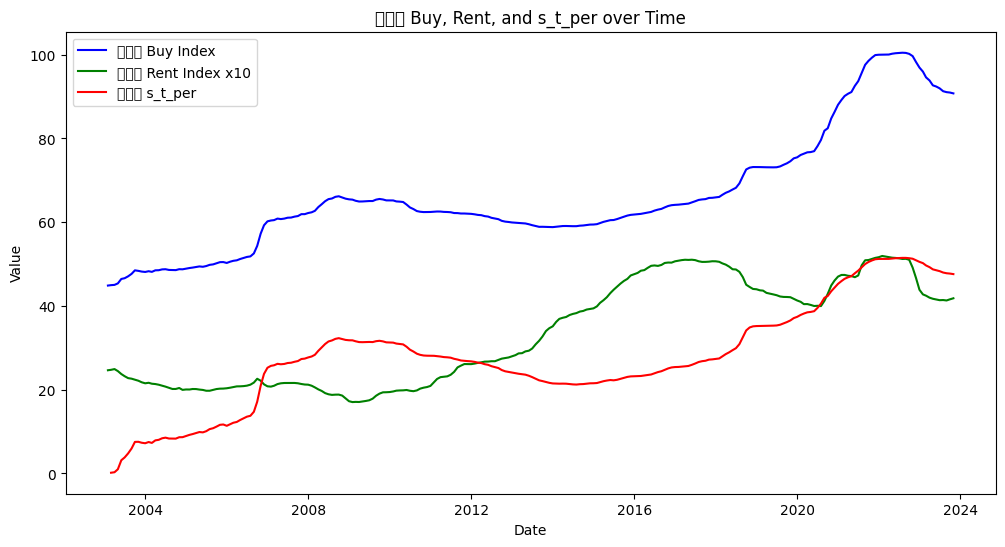

differential_evolution step 1: f(x)= 71.984
differential_evolution step 2: f(x)= 43.7007
differential_evolution step 3: f(x)= 43.7007
differential_evolution step 4: f(x)= 43.7007
differential_evolution step 5: f(x)= 43.7007
differential_evolution step 6: f(x)= 43.7007
differential_evolution step 7: f(x)= 42.3076
differential_evolution step 8: f(x)= 42.3076
differential_evolution step 9: f(x)= 42.3076
differential_evolution step 10: f(x)= 42.3076
differential_evolution step 11: f(x)= 41.9462
differential_evolution step 12: f(x)= 41.9462
differential_evolution step 13: f(x)= 41.8668
differential_evolution step 14: f(x)= 41.767
differential_evolution step 15: f(x)= 41.7194
differential_evolution step 16: f(x)= 41.7071
differential_evolution step 17: f(x)= 41.7071
differential_evolution step 18: f(x)= 41.6831
differential_evolution step 19: f(x)= 41.6749
differential_evolution step 20: f(x)= 41.6749
differential_evolution step 21: f(x)= 41.6733
differential_evolution step 22: f(x)= 41.6733

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


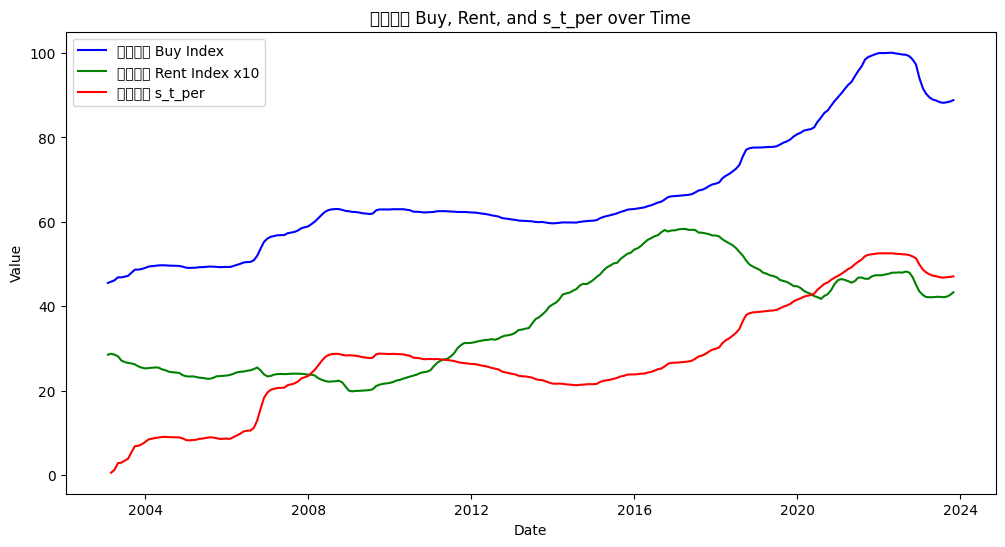

differential_evolution step 1: f(x)= 118.665
differential_evolution step 2: f(x)= 109.472
differential_evolution step 3: f(x)= 109.472
differential_evolution step 4: f(x)= 102.227
differential_evolution step 5: f(x)= 102.227
differential_evolution step 6: f(x)= 101.736
differential_evolution step 7: f(x)= 101.189
differential_evolution step 8: f(x)= 101.091
differential_evolution step 9: f(x)= 101.091
differential_evolution step 10: f(x)= 100.98
differential_evolution step 11: f(x)= 100.877
differential_evolution step 12: f(x)= 100.877
differential_evolution step 13: f(x)= 100.877
differential_evolution step 14: f(x)= 100.802
differential_evolution step 15: f(x)= 100.79
differential_evolution step 16: f(x)= 100.79
differential_evolution step 17: f(x)= 100.79
differential_evolution step 18: f(x)= 100.772
differential_evolution step 19: f(x)= 100.761
differential_evolution step 20: f(x)= 100.761
differential_evolution step 21: f(x)= 100.761
differential_evolution step 22: f(x)= 100.761
d

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


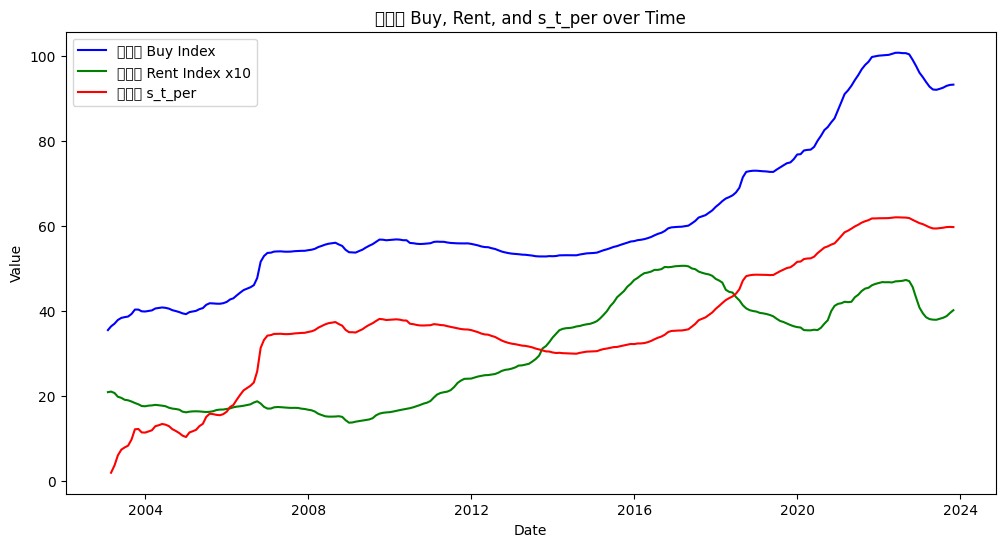

differential_evolution step 1: f(x)= 167.083
differential_evolution step 2: f(x)= 160.679
differential_evolution step 3: f(x)= 160.679
differential_evolution step 4: f(x)= 160.679
differential_evolution step 5: f(x)= 159.007
differential_evolution step 6: f(x)= 158.123
differential_evolution step 7: f(x)= 156.253
differential_evolution step 8: f(x)= 156.253
differential_evolution step 9: f(x)= 156.065
differential_evolution step 10: f(x)= 155.073
differential_evolution step 11: f(x)= 155.073
differential_evolution step 12: f(x)= 155.073
differential_evolution step 13: f(x)= 155.073
differential_evolution step 14: f(x)= 155.073
differential_evolution step 15: f(x)= 155.057
differential_evolution step 16: f(x)= 155.051
differential_evolution step 17: f(x)= 155.03
differential_evolution step 18: f(x)= 154.875
differential_evolution step 19: f(x)= 154.875
differential_evolution step 20: f(x)= 154.875
differential_evolution step 21: f(x)= 154.875
differential_evolution step 22: f(x)= 154.87

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


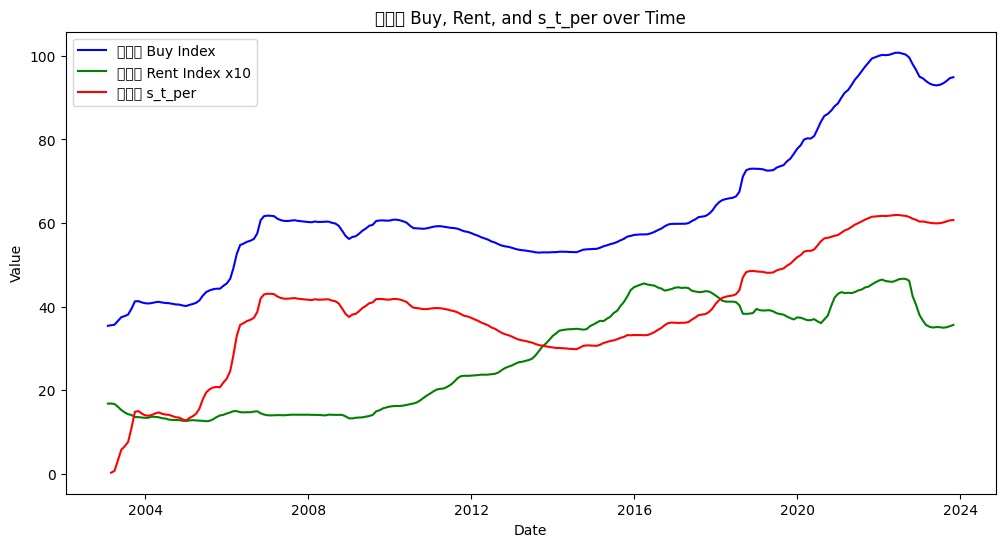

differential_evolution step 1: f(x)= 115.802
differential_evolution step 2: f(x)= 115.802
differential_evolution step 3: f(x)= 110.298
differential_evolution step 4: f(x)= 107.207
differential_evolution step 5: f(x)= 106.306
differential_evolution step 6: f(x)= 105.405
differential_evolution step 7: f(x)= 105.405
differential_evolution step 8: f(x)= 105.405
differential_evolution step 9: f(x)= 105.24
differential_evolution step 10: f(x)= 104.528
differential_evolution step 11: f(x)= 104.528
differential_evolution step 12: f(x)= 104.004
differential_evolution step 13: f(x)= 103.981
differential_evolution step 14: f(x)= 103.971
differential_evolution step 15: f(x)= 103.971
differential_evolution step 16: f(x)= 103.936
differential_evolution step 17: f(x)= 103.934
differential_evolution step 18: f(x)= 103.934
differential_evolution step 19: f(x)= 103.904
differential_evolution step 20: f(x)= 103.904
differential_evolution step 21: f(x)= 103.904
differential_evolution step 22: f(x)= 103.90

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


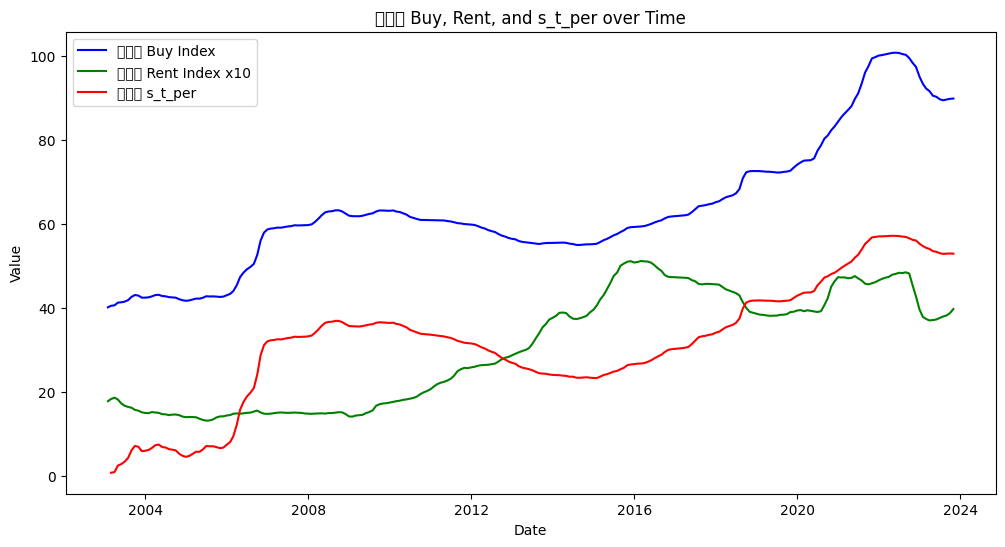

differential_evolution step 1: f(x)= 117.558
differential_evolution step 2: f(x)= 117.558
differential_evolution step 3: f(x)= 110.986
differential_evolution step 4: f(x)= 110.986
differential_evolution step 5: f(x)= 110.986
differential_evolution step 6: f(x)= 110.986
differential_evolution step 7: f(x)= 109.229
differential_evolution step 8: f(x)= 108.1
differential_evolution step 9: f(x)= 108.1
differential_evolution step 10: f(x)= 107.906
differential_evolution step 11: f(x)= 107.877
differential_evolution step 12: f(x)= 107.877
differential_evolution step 13: f(x)= 107.774
differential_evolution step 14: f(x)= 107.719
differential_evolution step 15: f(x)= 107.719
differential_evolution step 16: f(x)= 107.719
differential_evolution step 17: f(x)= 107.648
differential_evolution step 18: f(x)= 107.639
differential_evolution step 19: f(x)= 107.634
differential_evolution step 20: f(x)= 107.617
differential_evolution step 21: f(x)= 107.606
differential_evolution step 22: f(x)= 107.606
d

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


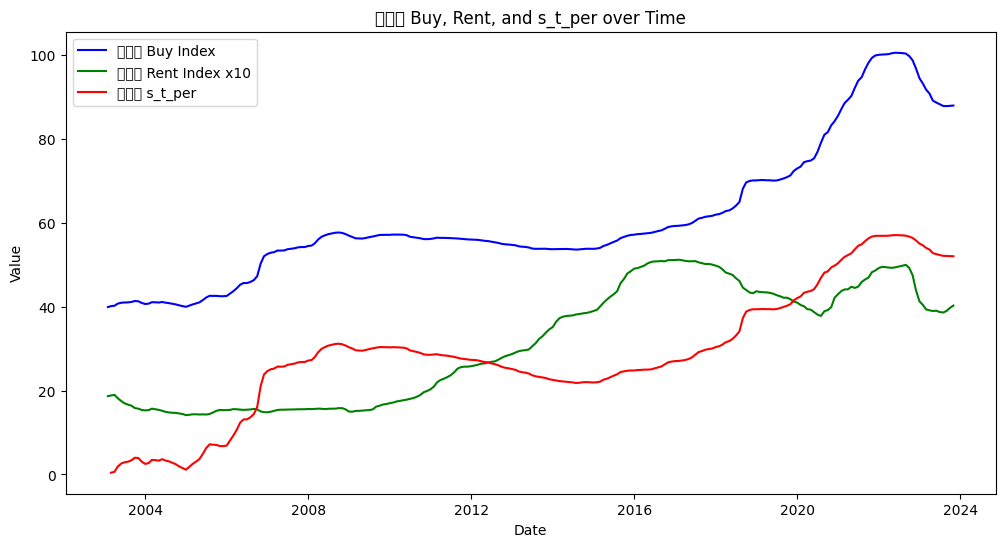

differential_evolution step 1: f(x)= 129.605
differential_evolution step 2: f(x)= 127.457
differential_evolution step 3: f(x)= 124.068
differential_evolution step 4: f(x)= 118.907
differential_evolution step 5: f(x)= 118.907
differential_evolution step 6: f(x)= 113.325
differential_evolution step 7: f(x)= 113.122
differential_evolution step 8: f(x)= 113.122
differential_evolution step 9: f(x)= 113.122
differential_evolution step 10: f(x)= 113.12
differential_evolution step 11: f(x)= 113.12
differential_evolution step 12: f(x)= 113.12
differential_evolution step 13: f(x)= 113.01
differential_evolution step 14: f(x)= 113.01
differential_evolution step 15: f(x)= 113.01
differential_evolution step 16: f(x)= 113.008
differential_evolution step 17: f(x)= 113.008
differential_evolution step 18: f(x)= 112.987
differential_evolution step 19: f(x)= 112.987
differential_evolution step 20: f(x)= 112.987
differential_evolution step 21: f(x)= 112.987
differential_evolution step 22: f(x)= 112.981
dif

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


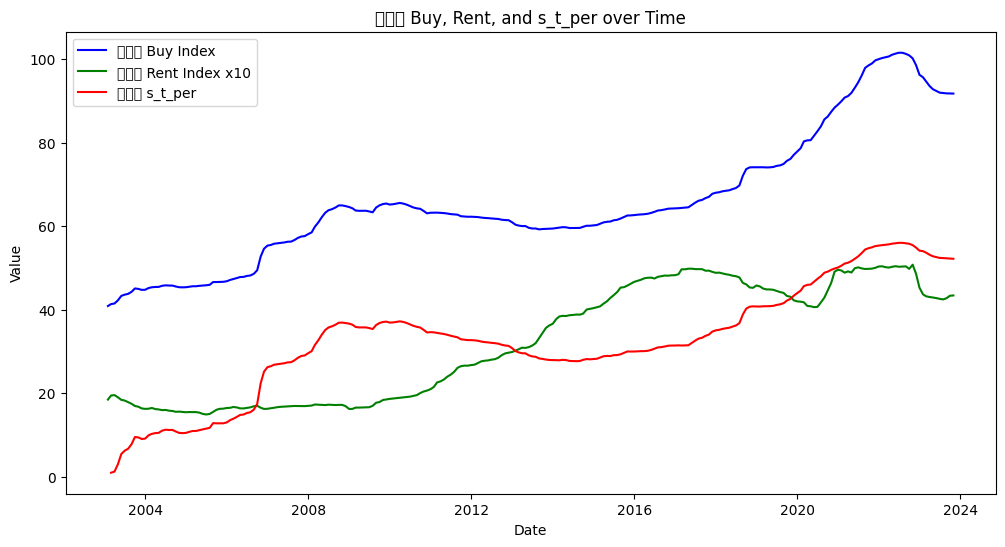

differential_evolution step 1: f(x)= 80.9415
differential_evolution step 2: f(x)= 80.9415
differential_evolution step 3: f(x)= 80.9415
differential_evolution step 4: f(x)= 67.906
differential_evolution step 5: f(x)= 67.906
differential_evolution step 6: f(x)= 64.3552
differential_evolution step 7: f(x)= 64.3552
differential_evolution step 8: f(x)= 64.3552
differential_evolution step 9: f(x)= 63.8154
differential_evolution step 10: f(x)= 63.8154
differential_evolution step 11: f(x)= 63.8154
differential_evolution step 12: f(x)= 63.8154
differential_evolution step 13: f(x)= 63.8154
differential_evolution step 14: f(x)= 63.6683
differential_evolution step 15: f(x)= 63.6073
differential_evolution step 16: f(x)= 63.5545
differential_evolution step 17: f(x)= 63.5545
differential_evolution step 18: f(x)= 63.5545
differential_evolution step 19: f(x)= 63.5143
differential_evolution step 20: f(x)= 63.5143
differential_evolution step 21: f(x)= 63.5143
differential_evolution step 22: f(x)= 63.5143

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


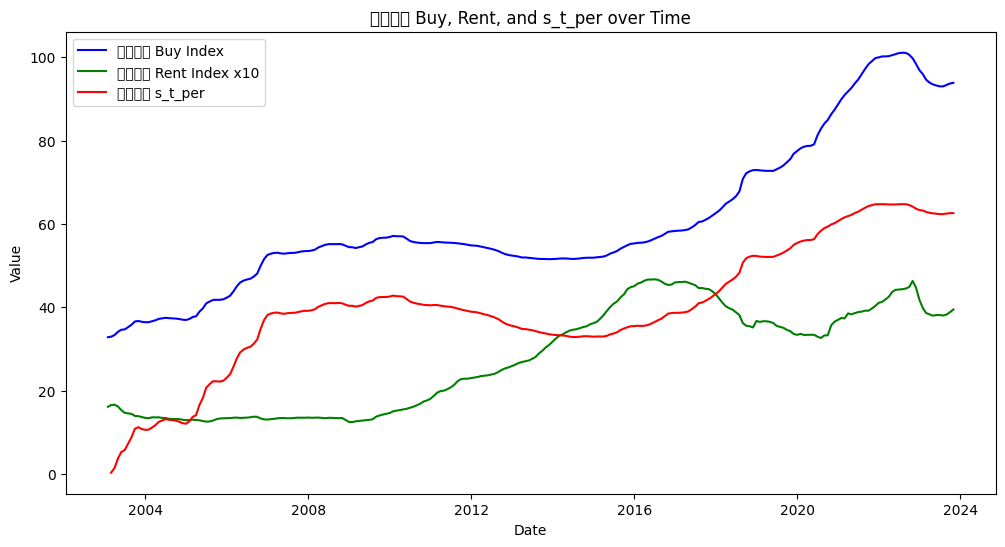

differential_evolution step 1: f(x)= 142.477
differential_evolution step 2: f(x)= 131.963
differential_evolution step 3: f(x)= 131.963
differential_evolution step 4: f(x)= 128.529
differential_evolution step 5: f(x)= 122.924
differential_evolution step 6: f(x)= 122.924
differential_evolution step 7: f(x)= 122.049
differential_evolution step 8: f(x)= 121.28
differential_evolution step 9: f(x)= 121.139
differential_evolution step 10: f(x)= 121.11
differential_evolution step 11: f(x)= 121.101
differential_evolution step 12: f(x)= 121.101
differential_evolution step 13: f(x)= 121.101
differential_evolution step 14: f(x)= 121.01
differential_evolution step 15: f(x)= 121.01
differential_evolution step 16: f(x)= 121.01
differential_evolution step 17: f(x)= 120.949
differential_evolution step 18: f(x)= 120.923
differential_evolution step 19: f(x)= 120.923
differential_evolution step 20: f(x)= 120.923
differential_evolution step 21: f(x)= 120.923
differential_evolution step 22: f(x)= 120.923
di

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


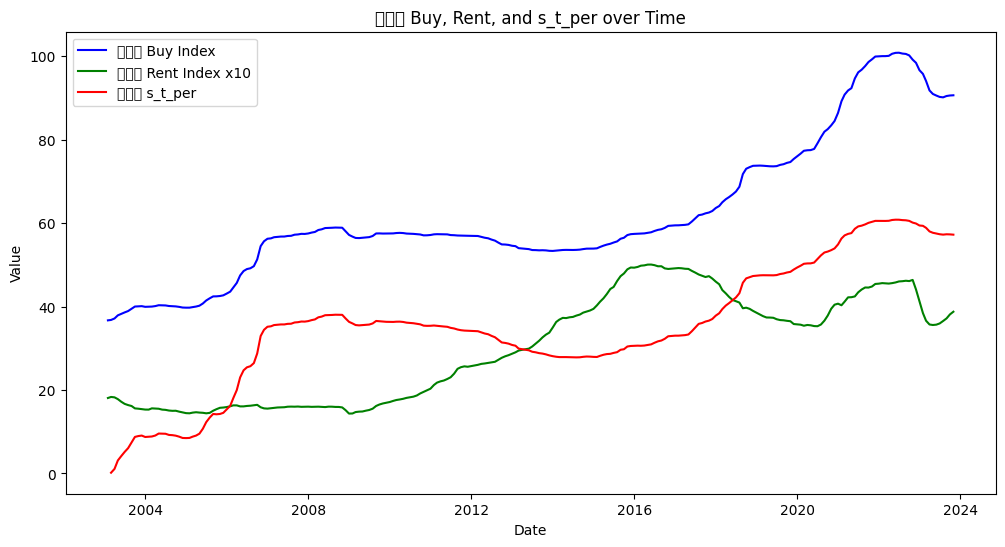

differential_evolution step 1: f(x)= 104.357
differential_evolution step 2: f(x)= 87.5806
differential_evolution step 3: f(x)= 87.5806
differential_evolution step 4: f(x)= 87.5806
differential_evolution step 5: f(x)= 87.5806
differential_evolution step 6: f(x)= 85.9935
differential_evolution step 7: f(x)= 85.0493
differential_evolution step 8: f(x)= 85.0493
differential_evolution step 9: f(x)= 85.0493
differential_evolution step 10: f(x)= 85.0493
differential_evolution step 11: f(x)= 85.0493
differential_evolution step 12: f(x)= 85.0493
differential_evolution step 13: f(x)= 85.0493
differential_evolution step 14: f(x)= 85.0493
differential_evolution step 15: f(x)= 84.9794
differential_evolution step 16: f(x)= 84.9631
differential_evolution step 17: f(x)= 84.9631
differential_evolution step 18: f(x)= 84.9512
differential_evolution step 19: f(x)= 84.9512
differential_evolution step 20: f(x)= 84.9512
differential_evolution step 21: f(x)= 84.936
differential_evolution step 22: f(x)= 84.880

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50501 (\N{HANGUL SYLLABLE AG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


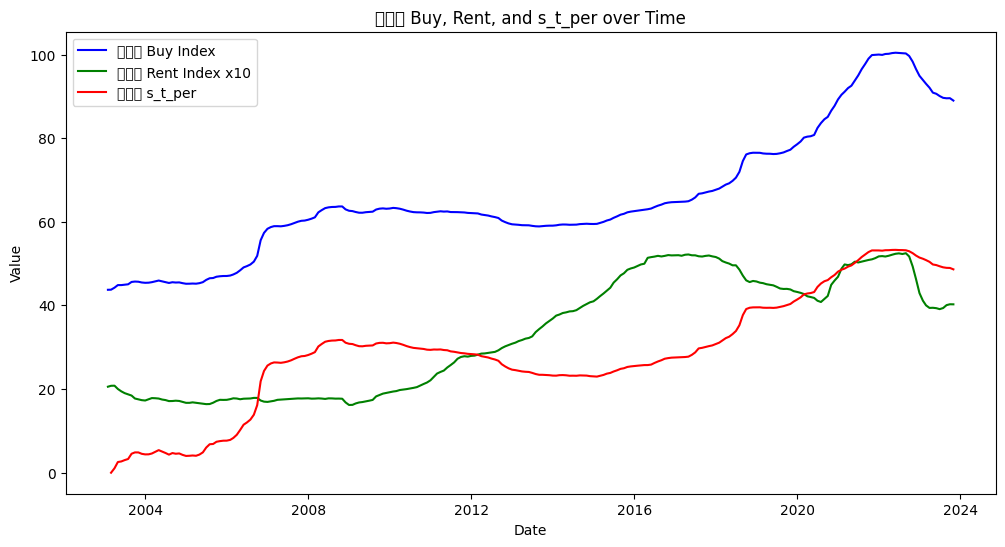

differential_evolution step 1: f(x)= 172.785
differential_evolution step 2: f(x)= 172.785
differential_evolution step 3: f(x)= 169.372
differential_evolution step 4: f(x)= 169.372
differential_evolution step 5: f(x)= 169.372
differential_evolution step 6: f(x)= 169.372
differential_evolution step 7: f(x)= 169.082
differential_evolution step 8: f(x)= 169.082
differential_evolution step 9: f(x)= 168.471
differential_evolution step 10: f(x)= 168.471
differential_evolution step 11: f(x)= 168.077
differential_evolution step 12: f(x)= 168.077
differential_evolution step 13: f(x)= 168.077
differential_evolution step 14: f(x)= 168.077
differential_evolution step 15: f(x)= 168.051
differential_evolution step 16: f(x)= 168.051
differential_evolution step 17: f(x)= 168.051
differential_evolution step 18: f(x)= 168.027
differential_evolution step 19: f(x)= 168.027
differential_evolution step 20: f(x)= 168.027
differential_evolution step 21: f(x)= 168.027
differential_evolution step 22: f(x)= 168.0

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


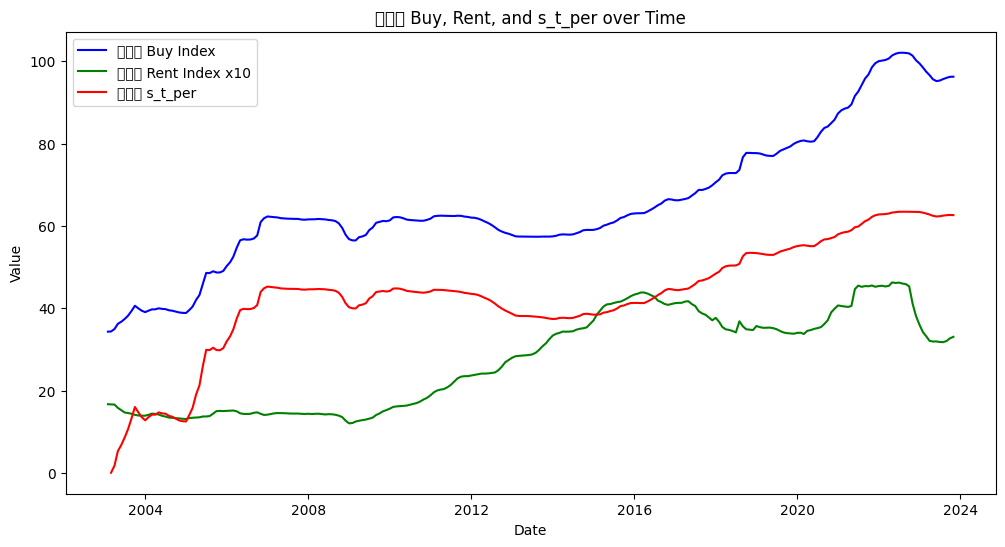

differential_evolution step 1: f(x)= 194.487
differential_evolution step 2: f(x)= 190.291
differential_evolution step 3: f(x)= 189.556
differential_evolution step 4: f(x)= 189.556
differential_evolution step 5: f(x)= 189.556
differential_evolution step 6: f(x)= 189.556
differential_evolution step 7: f(x)= 189.556
differential_evolution step 8: f(x)= 189.11
differential_evolution step 9: f(x)= 189.11
differential_evolution step 10: f(x)= 188.918
differential_evolution step 11: f(x)= 188.918
differential_evolution step 12: f(x)= 188.864
differential_evolution step 13: f(x)= 188.771
differential_evolution step 14: f(x)= 188.771
differential_evolution step 15: f(x)= 188.77
differential_evolution step 16: f(x)= 188.742
differential_evolution step 17: f(x)= 188.713
differential_evolution step 18: f(x)= 188.713
differential_evolution step 19: f(x)= 188.713
differential_evolution step 20: f(x)= 188.712
differential_evolution step 21: f(x)= 188.709
differential_evolution step 22: f(x)= 188.709


c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


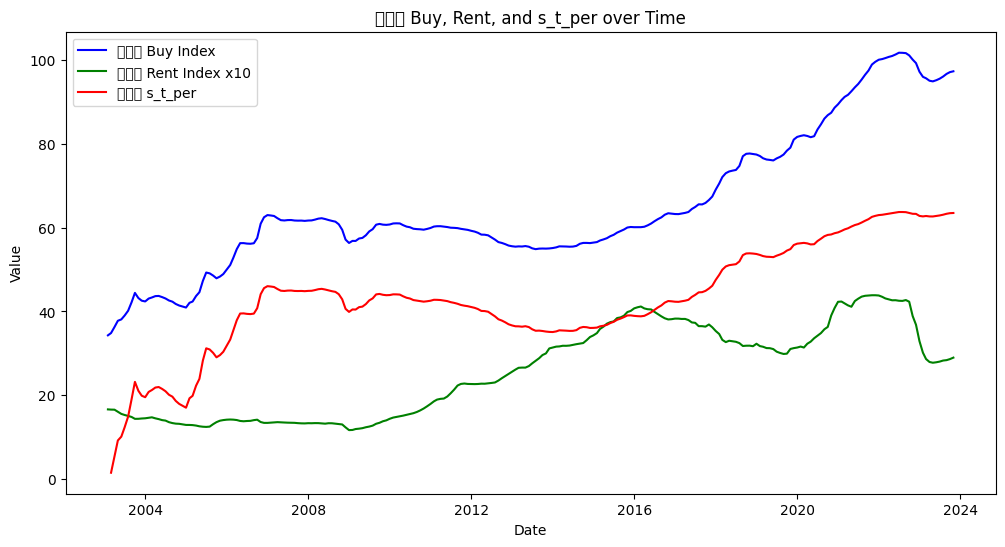

differential_evolution step 1: f(x)= 213.344
differential_evolution step 2: f(x)= 213.344
differential_evolution step 3: f(x)= 211.43
differential_evolution step 4: f(x)= 206.414
differential_evolution step 5: f(x)= 206.414
differential_evolution step 6: f(x)= 205.316
differential_evolution step 7: f(x)= 205.316
differential_evolution step 8: f(x)= 205.316
differential_evolution step 9: f(x)= 205.316
differential_evolution step 10: f(x)= 205.299
differential_evolution step 11: f(x)= 205.299
differential_evolution step 12: f(x)= 205.299
differential_evolution step 13: f(x)= 205.299
differential_evolution step 14: f(x)= 205.299
differential_evolution step 15: f(x)= 205.299
differential_evolution step 16: f(x)= 204.628
differential_evolution step 17: f(x)= 204.628
differential_evolution step 18: f(x)= 204.537
differential_evolution step 19: f(x)= 204.537
differential_evolution step 20: f(x)= 204.537
differential_evolution step 21: f(x)= 204.537
differential_evolution step 22: f(x)= 204.53

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49569 (\N{HANGUL SYLLABLE SONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


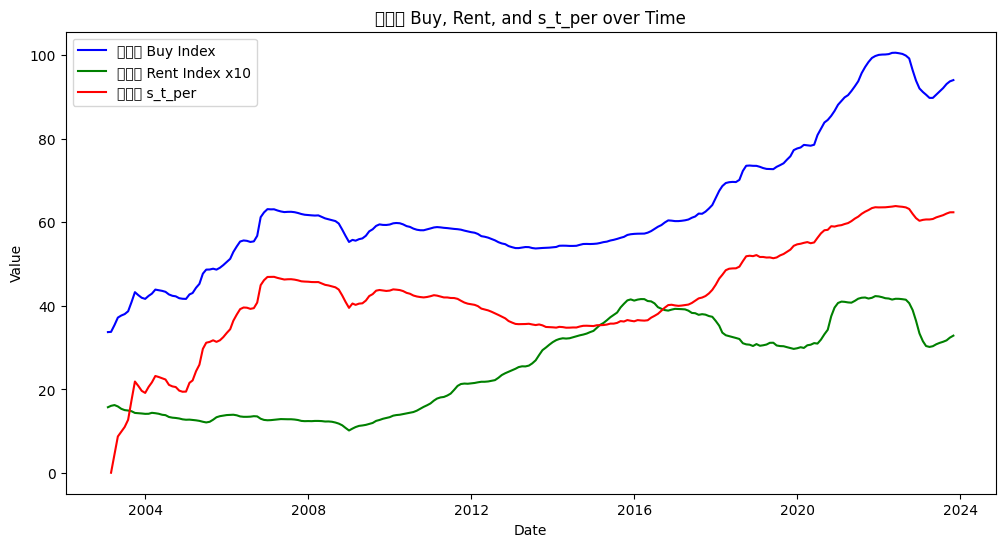

differential_evolution step 1: f(x)= 245.91
differential_evolution step 2: f(x)= 245.91
differential_evolution step 3: f(x)= 245.91
differential_evolution step 4: f(x)= 240.893
differential_evolution step 5: f(x)= 240.893
differential_evolution step 6: f(x)= 240.893
differential_evolution step 7: f(x)= 240.638
differential_evolution step 8: f(x)= 240.638
differential_evolution step 9: f(x)= 240.614
differential_evolution step 10: f(x)= 240.363
differential_evolution step 11: f(x)= 240.22
differential_evolution step 12: f(x)= 240.193
differential_evolution step 13: f(x)= 240.092
differential_evolution step 14: f(x)= 240.092
differential_evolution step 15: f(x)= 240.088
differential_evolution step 16: f(x)= 240.088
differential_evolution step 17: f(x)= 240.088
differential_evolution step 18: f(x)= 240.088
differential_evolution step 19: f(x)= 240.088
differential_evolution step 20: f(x)= 240.052
differential_evolution step 21: f(x)= 240.046
differential_evolution step 22: f(x)= 240.042
d

c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Chungeun Lee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


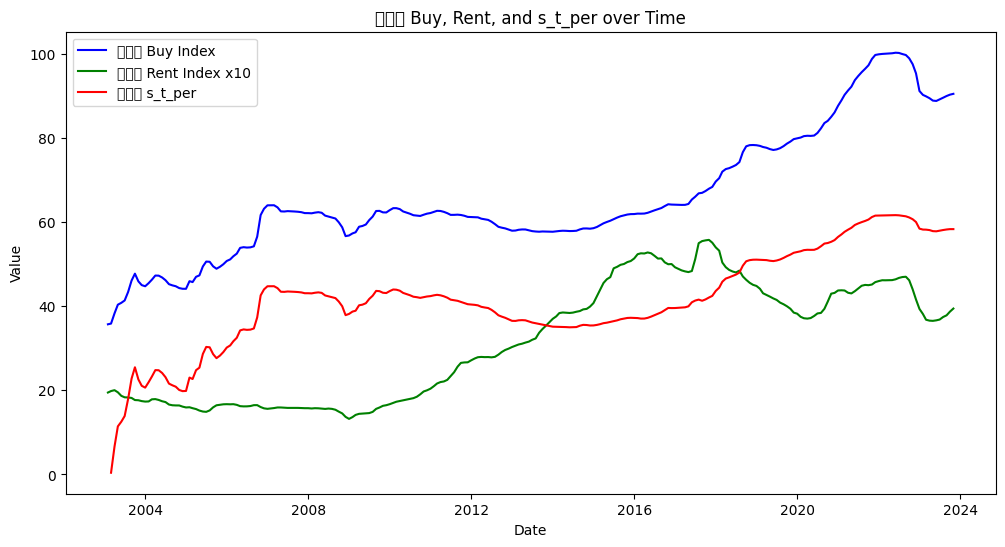

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_district(buy_data, rent_data, district_name, results_dict):
    buy_temp = pd.Series(buy_data[district_name].copy())
    rent_temp = pd.Series(rent_data[district_name].copy())
    y = buy_temp.diff().dropna() 
    x = rent_temp.diff().dropna()

    estimated_theta = estimate_parameters(y, x)
    beta, phi, sigma_b, sigma_s, sigma_zeta = estimated_theta
    rho = 1 / beta
    psi = 1 / (1 - phi * rho)
    z_estimates = run_kalman_filter(y, x, estimated_theta)

    # Extract delta b_t and calculate s_t
    Delta_s_t_series = [z[0] for z in z_estimates]
    initial_s_t = 0
    s_t_series = np.cumsum(np.insert(Delta_s_t_series, 0, initial_s_t))
    s_t_per = s_t_series / buy_temp[1:] * 100
    
    # Save s_t_per results
    results_dict[district_name] = s_t_per[1:] # Save without the initial value

    # Create a DataFrame
    df = pd.DataFrame({
        f'{district_name} Buy Index': buy_temp.iloc[1:], # Adjust for differencing
        f'{district_name} Rent Index': rent_temp.iloc[1:] * 10, # Multiply by 100
        f'{district_name} s_t_per': s_t_per[1:] # Adjust for differencing and initial value
    }, index=buy_temp.index[1:]) # Adjust index for differencing

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[f'{district_name} Buy Index'], label=f'{district_name} Buy Index', color='blue')
    plt.plot(df.index, df[f'{district_name} Rent Index'], label=f'{district_name} Rent Index x10', color='green')
    plt.plot(df.index, df[f'{district_name} s_t_per'], label=f'{district_name} s_t_per', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'{district_name} Buy, Rent, and s_t_per over Time')
    plt.legend()
    plt.show()

# Results dictionary to store s_t_per for each district
s_t_per_results = {}

# Iterate over all districts
for district in seoul_buy.columns:
    analyze_district(seoul_buy, seoul_rent, district, s_t_per_results)